Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# dSprites - Disentanglement testing Sprites dataset

## Description
Procedurally generated 2D shapes dataset. This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite (color isn't varying here, its value is fixed).

All possible combinations of the latents are present.

The ordering of images in the dataset (i.e. shape[0] in all ndarrays) is fixed and meaningful, see below.

We chose the smallest changes in latent values that generated different pixel outputs at our 64x64 resolution after rasterization.

No noise added, single image sample for a given latent setting.

## Details about the ordering of the dataset

The dataset was generated procedurally, and its order is deterministic.
For example, the image at index 0 corresponds to the latents (0, 0, 0, 0, 0, 0).

Then the image at index 1 increases the least significant "bit" of the latent:
(0, 0, 0, 0, 0, 1)

And similarly, till we reach index 32, where we get (0, 0, 0, 0, 1, 0). 

Hence the dataset is sequentially addressable using variable bases for every "bit".
Using dataset['metadata']['latents_sizes'] makes this conversion trivial, see below.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})


In [12]:
# Load dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x000002594BF5F490>)
Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       

In [17]:
#print(np.unique(latents_values[:, 1]))
#imgs.shape

rand_indices = np.random.permutation(np.arange(len(dataset_zip['imgs'])))[:100000]

#type(dataset_zip)
subset_old = dataset_zip['latents_values'][:100000]
subset_tmp = dataset_zip['latents_values'][np.random.permutation(np.arange(len(dataset_zip['imgs'])))[:100000]]
subset_cor = dataset_zip['latents_values'][rand_indices]
subset_imgs = dataset_zip['imgs'][rand_indices]

print(subset_old.shape)
print(subset_tmp.shape)
print(subset_imgs.shape)
print(subset_tmp[:10, 1])
print(subset_old[:10, 1])


(100000, 6)
(100000, 6)
(100000, 64, 64)
[2. 3. 3. 2. 2. 3. 3. 3. 3. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


3.0


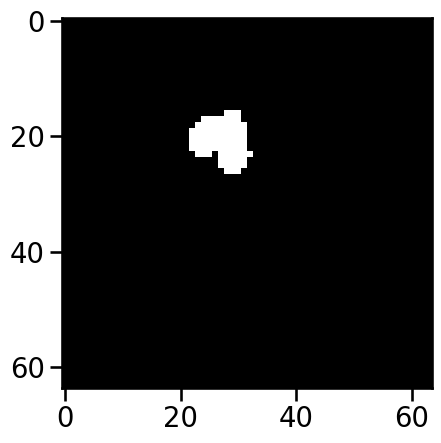

Label: 3.0


In [46]:
# Visualize data set and print dimensions
idx = np.random.randint(len(subset_cor))

test_features = subset_imgs[idx]
test_labels = subset_cor[idx, 1]
print(test_labels)
#print(f"Feature batch shape: {test_features.size()}")
#print(f"Labels batch shape: {test_labels.size()}")
img = test_features
label = test_labels
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [48]:
from __future__ import print_function
import os
import sys
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


class DisentangledSpritesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dir, subset_use=1.0, transform=None):
        """
        Args:
            dir (string): Directory containing the dSprites dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dir = dir
        self.filename = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
        self.filepath = f'{self.dir}/{self.filename}'
        dataset_zip = np.load(self.filepath, allow_pickle=True, encoding='bytes')

        #print('Keys in the dataset:', dataset_zip.keys())
        dataset_size = len(dataset_zip['imgs'])
        subset_size = int(np.floor(subset_use*dataset_size))
        rand_indices = np.random.permutation(np.arange(dataset_size))[:subset_size]

        self.imgs = dataset_zip['imgs'][rand_indices]
        self.latents_values = dataset_zip['latents_values'][rand_indices]
        self.latents_classes = dataset_zip['latents_classes'][rand_indices]
        self.metadata = dataset_zip['metadata'][()]

        # print('Metadata: \n', self.metadata)
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        sample = self.imgs[idx].astype(np.float32)
        label = self.latents_values[idx,1].astype(np.int16) # 1 for shape labels
        # sample = sample.reshape(1, sample.shape[0], sample.shape[1])
        if self.transform:
            sample = self.transform(sample)
        return sample, label


def load_dsprites(dir='/home/genyrosk/datasets',
                val_split=0.9, subset_use = 1.0, shuffle=True, seed=42, batch_size=64):
    # img_size = 64
    path = os.path.join(dir, '')
    dataset = DisentangledSpritesDataset(path, subset_use, transform=transforms.ToTensor())

    # Create data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Create data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_size = len(train_sampler)
    val_size = len(val_sampler)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

In [49]:
train_data, test_data = load_dsprites(dir = os.getcwd(), subset_use=0.1, batch_size = 128)

tensor([2, 2, 3, 3, 3, 1, 2, 1, 3, 1, 3, 2, 3, 2, 1, 2, 1, 3, 3, 1, 2, 1, 2, 1,
        2, 3, 2, 1, 1, 1, 1, 2, 3, 1, 1, 3, 1, 3, 2, 3, 3, 1, 2, 3, 3, 3, 1, 2,
        2, 1, 2, 2, 1, 3, 1, 3, 3, 2, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3, 1, 1, 2, 2,
        1, 1, 3, 2, 3, 3, 2, 3, 3, 3, 1, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 2, 2, 2,
        2, 2, 3, 2, 1, 1, 3, 3, 2, 2, 1, 3, 2, 3, 1, 3, 3, 2, 1, 3, 2, 3, 3, 2,
        2, 1, 3, 1, 2, 2, 1, 1], dtype=torch.int16)
Feature batch shape: torch.Size([128, 1, 64, 64])
Labels batch shape: torch.Size([128])


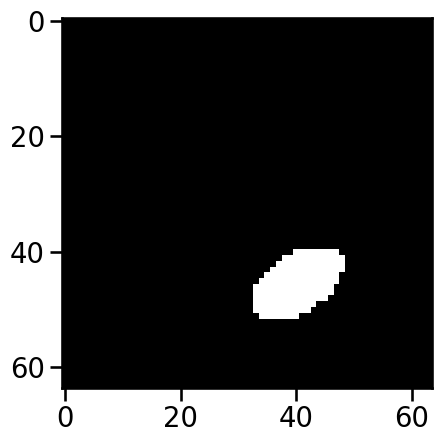

Label: 2


In [54]:
# Visualize data set and print dimensions
test_features, test_labels = next(iter(test_data))
print(test_labels)
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples


In [ ]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

## Randomly sampling into the dataset

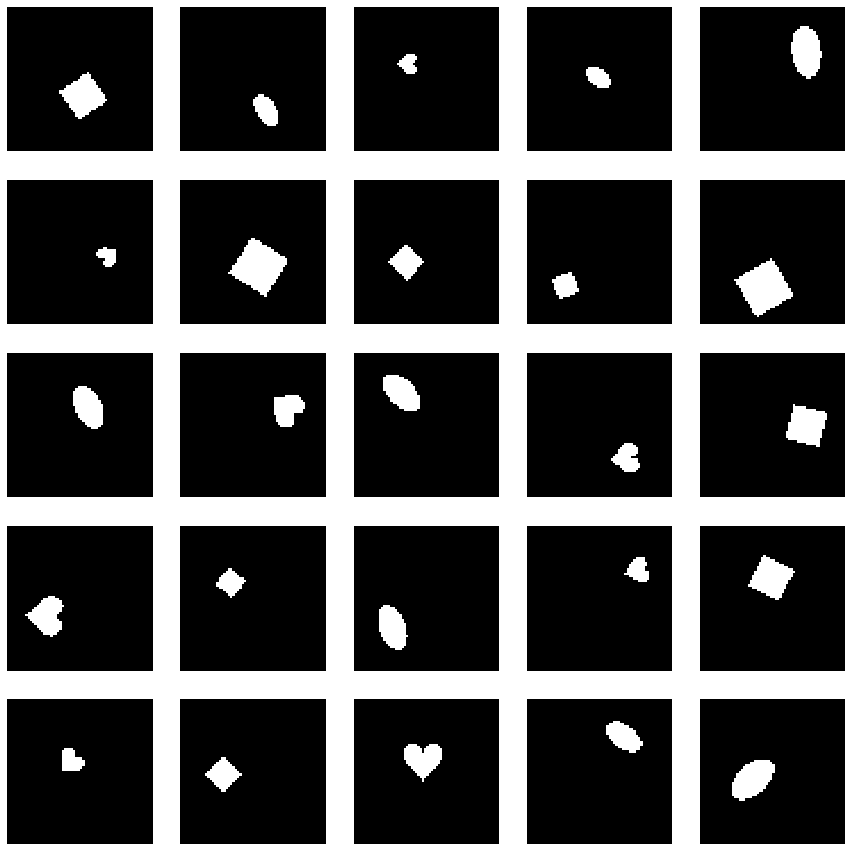

In [24]:
# Sample latents randomly
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
show_images_grid(imgs_sampled)

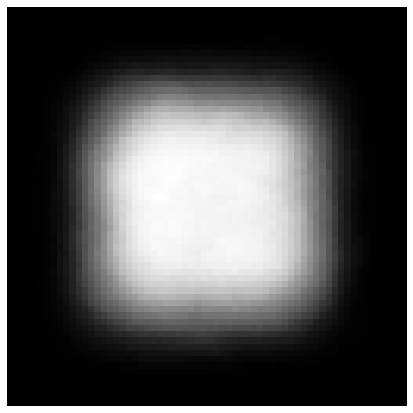

In [25]:
# Compute the density of the data to show that no pixel ever goes out of
# the boundary. Obviously it also means that the main support of the pixels is in the center
# half. 
# Locations cover a square, which make the aligned X-Y latents more likely for
# models to discover.

show_density(imgs_sampled)

## Conditional sampling of the dataset

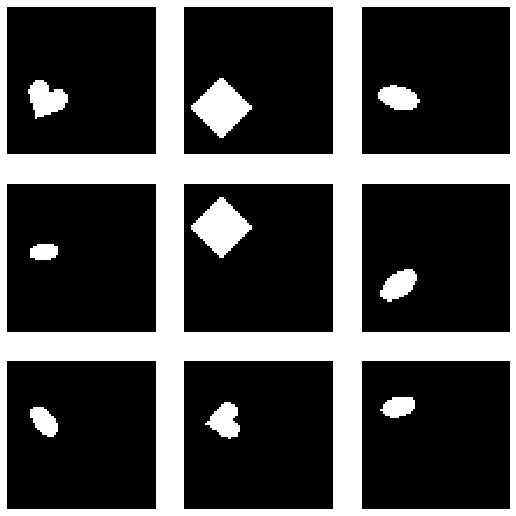

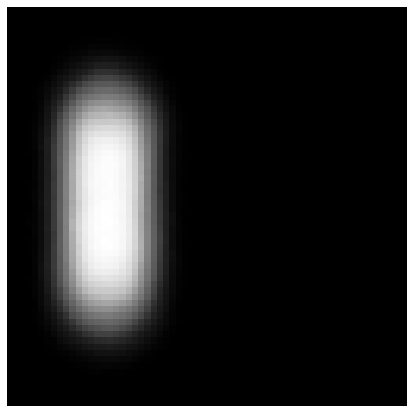

In [27]:
## Fix posX latent to left
latents_sampled = sample_latent(size=5000)
latents_sampled[:, -2] = 0
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Show the density too to check
show_density(imgs_sampled)

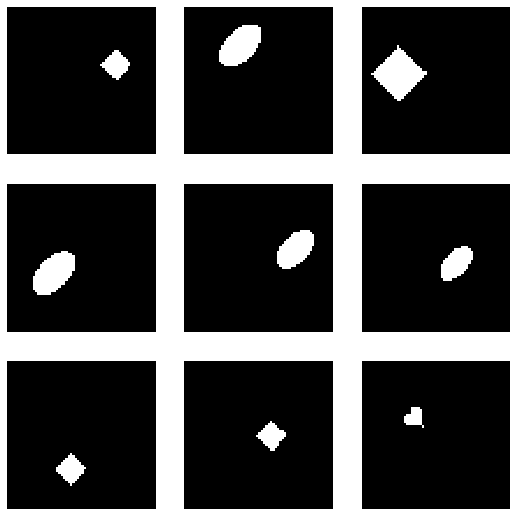

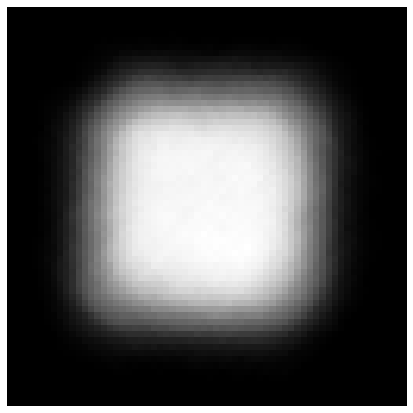

In [29]:
## Fix orientation to 0.8 rad
latents_sampled = sample_latent(size=5000)
latents_sampled[:, 3] = 5
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Density should not be different than for all orientations
show_density(imgs_sampled)